In [1]:
import pandas as pd

In [2]:
spine_messages_files= [
    "s3://prm-gp2gp-raw-spine-data-preprod/v2/messages/2021/7/2021-7_spine_messages.csv.gz",
    "s3://prm-gp2gp-raw-spine-data-preprod/v2/messages/2021/8/2021-8_spine_messages.csv.gz",
    "s3://prm-gp2gp-raw-spine-data-preprod/v2/messages/2021/9/2021-9_spine_messages.csv.gz"
]

spine_messages = (
    pd.concat((pd.read_csv(f, dtype=str) for f in spine_messages_files))
)

spine_messages["_time"] = pd.to_datetime(spine_messages["_time"])

In [3]:
is_gp2gp_request = spine_messages["interactionID"] == "urn:nhs:names:services:gp2gp/RCMR_IN010000UK05"
gp2gp_requests = (
    spine_messages[is_gp2gp_request]
        .groupby("conversationID")
        .head(1)
        .rename(columns={"_time": "requested_time"})
        .set_index("conversationID")
        [["requested_time"]]
)


In [4]:
is_ehr_request_completed = spine_messages["interactionID"] == "urn:nhs:names:services:gp2gp/RCMR_IN030000UK06"
ehr_req_completed_messages = (spine_messages[is_ehr_request_completed]
    .rename(columns={"_time": "ehr_sent_time"})
    .set_index("conversationID")   
    .join(gp2gp_requests)
)

In [5]:
ehr_sent_timedelta = ehr_req_completed_messages["ehr_sent_time"] - ehr_req_completed_messages["requested_time"]
sent_after_one_day = ehr_sent_timedelta > pd.Timedelta(days=1)


In [6]:
sent_after_one_day.value_counts()

False    741259
True      15836
dtype: int64

In [7]:
print(sent_after_one_day.value_counts() / len(ehr_sent_timedelta) * 100)

False    97.908321
True      2.091679
dtype: float64


<AxesSubplot:title={'center':'EHR Request completed messages sent after a day'}>

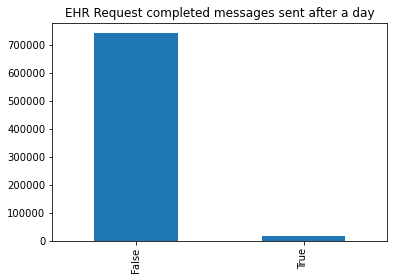

In [8]:
sent_after_one_day.value_counts().plot.bar(title="EHR Request completed messages sent after a day")